# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#подключение необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, cv, train
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import time
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
#подключение и просмотр данных
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В данных наблюдаются пропуски. Удалим столбцы, которые в данном исследовании не пригодятся. Но сначала приведем все названия столбцов к змеиному стилю.

In [4]:
#переименование столбцов
data.columns=['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox', 'power', 'model', 'kilometer',
              'registration_month', 'fuel_type', 'brand', 'repaired', 'date_created', 'number_of_pictures', 'postal_code',
              'last_seen']

In [5]:
#проверка
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
#удаление ненужных столбцов
data = (data.drop(columns=['date_crawled', 'model', 'registration_month', 'date_created', 'last_seen', 'number_of_pictures'],
                axis=1))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   kilometer          354369 non-null  int64 
 6   fuel_type          321474 non-null  object
 7   brand              354369 non-null  object
 8   repaired           283215 non-null  object
 9   postal_code        354369 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 27.0+ MB


In [7]:
#проверка на дубликаты
data.duplicated().sum()

24387

In [8]:
#удаление дубликатов
data = data.drop_duplicates()
data.duplicated().sum()

0

Теперь попробуем обработать значительные пропуски в оставшихся данных. Сначала обработаем численные значения. Потом категориальные.

Сначала посмотрим на данные в ключевом признаке **price**.

In [9]:
#нахождение пустых значений
data['price'].isna().sum()

0

In [10]:
#уникальные значения
data['price'].value_counts()

0        9876
500      5447
1500     5062
1000     4374
1200     4319
         ... 
4725        1
14960       1
1910        1
1654        1
8188        1
Name: price, Length: 3731, dtype: int64

<AxesSubplot:>

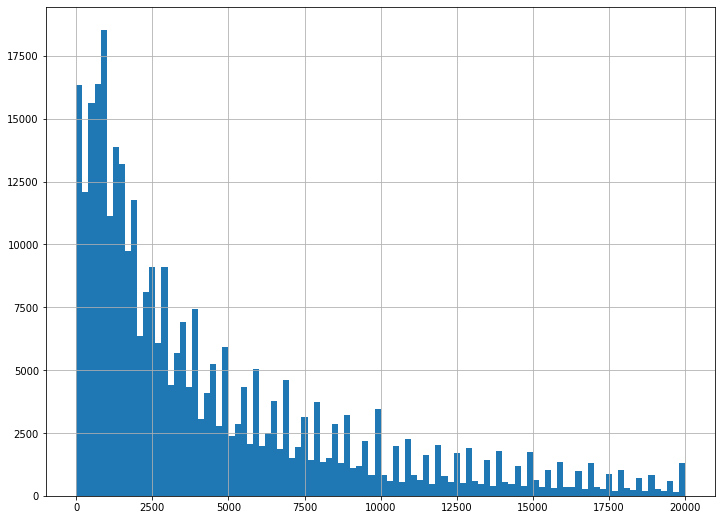

In [11]:
#посмотрим на графике
data['price'].hist(bins=100, figsize=(12,9))

У нас есть приличное количество значений с 0, удалим их.

In [12]:
#удаление нулевых значений
data = data.loc[data['price'] != 0]

#нахождение оптимальных значений
data['price'].quantile([0.2, 0.88])

0.20      950.0
0.88    10500.0
Name: price, dtype: float64

In [13]:
#фильтрация
data = data.query('950 <= price')

<AxesSubplot:>

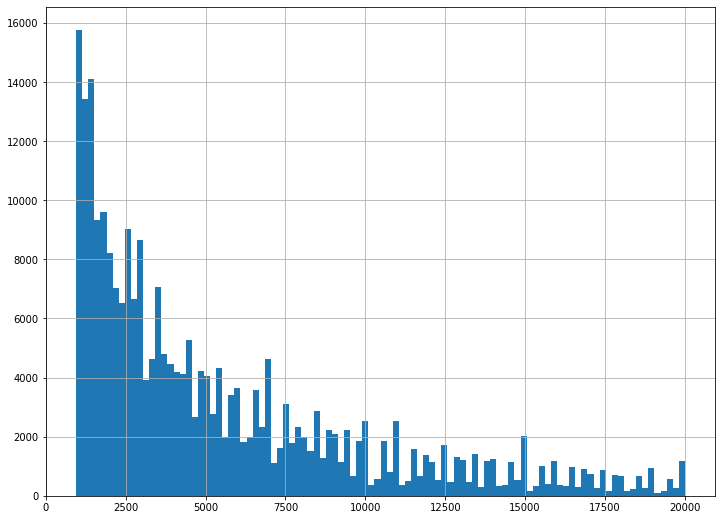

In [14]:
#посмотрим на графике
data['price'].hist(bins=100, figsize=(12,9))

Теперь посмотрим на данные в **registration_year**.

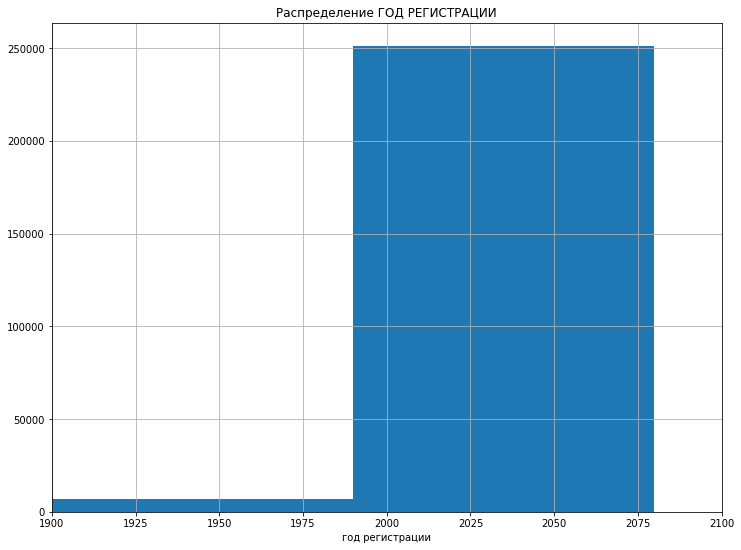

In [15]:
#посмотрим на графике
data['registration_year'].hist(bins=100, figsize=(12,9))
plt.xlim(1900,2100)
plt.grid(True)
plt.xlabel('год регистрации')
plt.title('Распределение ГОД РЕГИСТРАЦИИ')
plt.show()

Видим, что основные данные у нас находятся в приблизительном промежутке 1985-2022 год. Эти данные и оставим. Остальные уберем.

In [16]:
#отбор нужных данных по найденному диапазону
data = data.query('1985 <= registration_year <= 2022')
#проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254014 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              254014 non-null  int64 
 1   vehicle_type       234038 non-null  object
 2   registration_year  254014 non-null  int64 
 3   gearbox            244611 non-null  object
 4   power              254014 non-null  int64 
 5   kilometer          254014 non-null  int64 
 6   fuel_type          237109 non-null  object
 7   brand              254014 non-null  object
 8   repaired           213965 non-null  object
 9   postal_code        254014 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 21.3+ MB


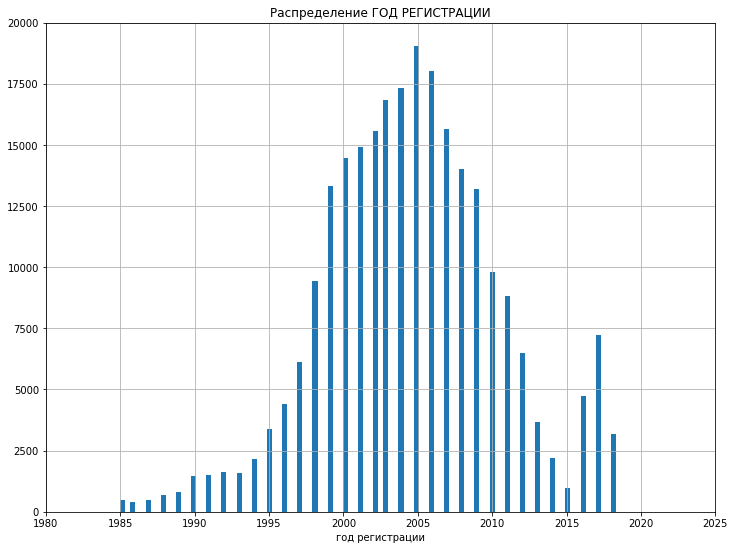

In [17]:
#посмотрим, что получилось в итоге
data['registration_year'].hist(bins=100, figsize=(12,9))
plt.xlim(1980,2025)
plt.grid(True)
plt.xlabel('год регистрации')
plt.title('Распределение ГОД РЕГИСТРАЦИИ')
plt.show()

Отлично. Теперь посмотрим, что у нас за значения в столбце **power**. 

In [18]:
#изучение данных
data['power'].describe()

count    254014.000000
mean        120.774182
std         196.502176
min           0.000000
25%          75.000000
50%         115.000000
75%         150.000000
max       20000.000000
Name: power, dtype: float64

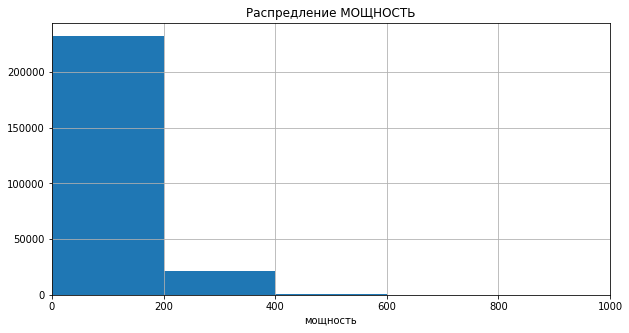

In [19]:
#посмотрим на данные
data['power'].hist(bins=100, figsize=(10,5))
plt.xlim(0, 1000)
plt.grid(True)
plt.xlabel('мощность')
plt.title('Распредление МОЩНОСТЬ')
plt.show()

Видно, что есть большая часть значений сосредоточена в районе до 400 л.с. Кроме этого есть машины с мощностью 0 л.с., что невполне корректно. Отсортируем данные в соответствии с этим диапазоном.

<AxesSubplot:>

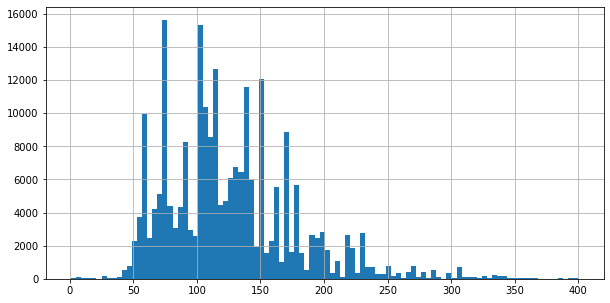

In [20]:
#фильтрация данных
data = data.query('power != 0')
data = data.query('power <= 400')
#посмотрим на данные
data['power'].hist(bins=100, figsize=(10,5))

In [21]:
#посмотрим на оставшиеся данные
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233656 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              233656 non-null  int64 
 1   vehicle_type       219618 non-null  object
 2   registration_year  233656 non-null  int64 
 3   gearbox            229678 non-null  object
 4   power              233656 non-null  int64 
 5   kilometer          233656 non-null  int64 
 6   fuel_type          220975 non-null  object
 7   brand              233656 non-null  object
 8   repaired           202663 non-null  object
 9   postal_code        233656 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 19.6+ MB


Итак, пропуски остались в столбцах **vehicle_type, gearbox, fuel_type, repaired**. Заполним пустые значения в категориальных признаках **gearbox, rapaired** наибольшими значениями.

In [22]:
#просмотр значений столбца gearbox
data['gearbox'].value_counts()

manual    178879
auto       50799
Name: gearbox, dtype: int64

In [23]:
#просмотр значений столбца repaired
data['repaired'].value_counts()

no     187368
yes     15295
Name: repaired, dtype: int64

In [24]:
#заполнение пустых значений
data.fillna({'gearbox':'manual', 'repaired':'no'}, inplace=True)

In [25]:
#просмтотр оставшихся пропусков
data.isna().sum()

price                    0
vehicle_type         14038
registration_year        0
gearbox                  0
power                    0
kilometer                0
fuel_type            12681
brand                    0
repaired                 0
postal_code              0
dtype: int64

Пропущенные значений остались в столбцах **vehicle_type, fuel_type**. Постараемся найти зависимость и понять, какие значения могут быть в пропусках. 

In [26]:
#просмотр уникальных значений
data['vehicle_type'].value_counts()

sedan          64752
wagon          47133
small          46165
bus            22727
convertible    16114
coupe          11320
suv             9586
other           1821
Name: vehicle_type, dtype: int64

Больше всего sedan. Попробуем заполнить пустые значения заглушкой 'unknown', а после заполнить их с помощью функции наиболее встречающимися для марки типом кузова.

In [27]:
#Построим сводную таблицу
vehicle_type_table = data.pivot_table(index=['vehicle_type'], columns=['brand'], values=['price'],\
                                      aggfunc=['count'])
vehicle_type_table = vehicle_type_table['count']['price']
vehicle_type_table

brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
vehicle_type,,,,,,,,,,,,,,,,,,,,,
bus,NaN,9.0,3.0,121.0,256.0,992.0,39.0,18.0,18.0,621.0,...,527.0,202.0,NaN,119.0,11.0,19.0,395.0,NaN,7877.0,NaN
convertible,132.0,1409.0,2777.0,10.0,174.0,80.0,NaN,NaN,15.0,330.0,...,NaN,2.0,982.0,143.0,1.0,21.0,54.0,14.0,2189.0,65.0
coupe,175.0,1272.0,2770.0,39.0,36.0,95.0,NaN,1.0,NaN,109.0,...,64.0,NaN,265.0,75.0,6.0,2.0,153.0,1.0,1235.0,45.0
other,5.0,70.0,147.0,16.0,7.0,73.0,5.0,2.0,3.0,111.0,...,33.0,18.0,4.0,78.0,3.0,8.0,13.0,1.0,460.0,3.0
sedan,608.0,7863.0,13796.0,163.0,169.0,451.0,84.0,38.0,31.0,525.0,...,1372.0,712.0,25.0,224.0,120.0,117.0,733.0,54.0,14430.0,460.0
small,179.0,1181.0,268.0,469.0,7.0,1087.0,195.0,121.0,235.0,2831.0,...,1998.0,905.0,2613.0,130.0,52.0,623.0,1241.0,22.0,10473.0,5.0
suv,NaN,98.0,629.0,286.0,15.0,29.0,187.0,1.0,31.0,22.0,...,4.0,157.0,NaN,305.0,47.0,613.0,381.0,1.0,1058.0,163.0
wagon,324.0,8992.0,6351.0,85.0,200.0,401.0,208.0,18.0,13.0,219.0,...,265.0,2285.0,7.0,81.0,181.0,51.0,483.0,24.0,9197.0,1261.0


In [28]:
#заполним пропуски unknown
data.fillna({'vehicle_type': 'unknown'},inplace=True)

#функция
def fillna_by_brand(row, row_number, vehicle_type_table):
    brand = row[7]
    fill_value = row[row_number]
    if row[row_number] == 'unknown':
        fill_value = vehicle_type_table[brand].idxmax()
    return fill_value

#проба фунцкии
data['vehicle_type'] = data.apply(fillna_by_brand, args=[1, vehicle_type_table], axis=1)
display(data['vehicle_type'].isna().sum())
data['vehicle_type'].value_counts()

0

sedan          71619
small          51606
wagon          48609
bus            22769
convertible    16129
coupe          11320
suv             9783
other           1821
Name: vehicle_type, dtype: int64

Получилось. Аналогично сделаем и для столбца **fuel_type**. 

In [29]:
#Построим сводную таблицу
fuel_type_table = data.pivot_table(index=['fuel_type'], columns=['brand'], values=['price'],\
                                      aggfunc=['count'])
fuel_type_table = fuel_type_table['count']['price']
fuel_type_table

brand,alfa_romeo,audi,bmw,chevrolet,chrysler,citroen,dacia,daewoo,daihatsu,fiat,...,seat,skoda,smart,sonstige_autos,subaru,suzuki,toyota,trabant,volkswagen,volvo
fuel_type,,,,,,,,,,,,,,,,,,,,,
cng,NaN,NaN,5.0,4.0,NaN,5.0,2.0,NaN,NaN,55.0,...,1.0,6.0,2.0,3.0,1.0,NaN,NaN,NaN,153.0,17.0
electric,NaN,1.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,1.0,...,NaN,NaN,7.0,14.0,NaN,NaN,NaN,NaN,2.0,NaN
gasoline,462.0,10191.0,10271.0,191.0,296.0,1248.0,175.0,1.0,3.0,1100.0,...,1372.0,1677.0,711.0,322.0,38.0,192.0,867.0,1.0,20521.0,857.0
hybrid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,NaN,1.0,19.0,NaN,NaN,109.0,NaN,2.0,NaN
lpg,24.0,360.0,606.0,145.0,67.0,50.0,44.0,17.0,2.0,53.0,...,47.0,42.0,2.0,100.0,22.0,13.0,18.0,NaN,380.0,73.0
other,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,1.0,NaN,13.0,10.0,1.0
petrol,940.0,10376.0,15589.0,847.0,495.0,1934.0,487.0,185.0,340.0,3659.0,...,2972.0,2536.0,3204.0,685.0,352.0,1257.0,2485.0,87.0,26836.0,1033.0


In [30]:
#заполним пропуски unknown
data.fillna({'fuel_type': 'unknown'},inplace=True)

#проба фунцкии
data['fuel_type'] = data.apply(fillna_by_brand, args=[6, fuel_type_table], axis=1)
display(data['fuel_type'].isna().sum())
data['fuel_type'].value_counts()

0

petrol      149865
gasoline     79110
lpg           3942
cng            429
hybrid         186
electric        68
other           56
Name: fuel_type, dtype: int64

In [31]:
#итоговая проверка
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233656 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              233656 non-null  int64 
 1   vehicle_type       233656 non-null  object
 2   registration_year  233656 non-null  int64 
 3   gearbox            233656 non-null  object
 4   power              233656 non-null  int64 
 5   kilometer          233656 non-null  int64 
 6   fuel_type          233656 non-null  object
 7   brand              233656 non-null  object
 8   repaired           233656 non-null  object
 9   postal_code        233656 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 19.6+ MB


In [32]:
#итоговая проверка
data.head()

,price,vehicle_type,registration_year,gearbox,power,kilometer,fuel_type,brand,repaired,postal_code
1,18300,coupe,2011,manual,190,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,125000,gasoline,jeep,no,90480
3,1500,small,2001,manual,75,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,90000,gasoline,skoda,no,60437
6,2200,convertible,2004,manual,109,150000,petrol,peugeot,no,67112


Вроде бы все данные проверены, пропусков больше нет. Приступим в обучению.

## Обучение моделей

Подготовим данные к обучению.

In [55]:
#базовые  признаки
features = data.drop(['price'], axis=1)
target = data[['price']]

#деление на выборки
features_80, features_test, target_80, target_test = train_test_split(
    features, target, test_size=0.20, random_state=12345)
features_train, features_valid, target_train, target_valid = train_test_split(
    features_80, target_80, test_size=0.25, random_state=12345)

#кодирование методом OE
encoder = OrdinalEncoder(dtype=np.int16, handle_unknown='ignore')
cat_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'repaired']
encoder.fit(features_train[cat_columns])

#преобразование выборок кодированием
features_train[cat_columns] = encoder.transform(features_train[cat_columns])

features_valid[cat_columns] = encoder.transform(features_valid[cat_columns])

features_test[cat_columns] = encoder.transform(features_test[cat_columns])

features_80[cat_columns] = encoder.transform(features_80[cat_columns])


### CatBoost

Подберем оптимальное значение RMSE и глубину в цикле для Градиентного бустинга.

0:	learn: 3781.2225311	total: 81.7ms	remaining: 2.37s
5:	learn: 2916.4356999	total: 188ms	remaining: 754ms
10:	learn: 2665.8954483	total: 296ms	remaining: 512ms
15:	learn: 2490.6958698	total: 421ms	remaining: 368ms
20:	learn: 2430.4687382	total: 553ms	remaining: 237ms
25:	learn: 2370.1938603	total: 657ms	remaining: 101ms
29:	learn: 2340.0429354	total: 740ms	remaining: 0us
0:	learn: 2716.2290525	total: 50.7ms	remaining: 1.47s
5:	learn: 2045.1847442	total: 284ms	remaining: 1.14s
10:	learn: 1939.3206883	total: 499ms	remaining: 862ms
15:	learn: 1881.6404661	total: 726ms	remaining: 635ms
20:	learn: 1842.9155999	total: 1.04s	remaining: 445ms
25:	learn: 1815.2542460	total: 1.26s	remaining: 195ms
29:	learn: 1795.5028837	total: 1.56s	remaining: 0us
0:	learn: 2423.3616074	total: 101ms	remaining: 2.92s
5:	learn: 1857.5496863	total: 593ms	remaining: 2.37s
10:	learn: 1774.8862199	total: 1.06s	remaining: 1.83s
15:	learn: 1700.0559666	total: 1.52s	remaining: 1.33s
20:	learn: 1663.7101529	total: 2.04s

1346.5116875688022

16

CPU times: user 35.3 s, sys: 14.3 s, total: 49.6 s
Wall time: 52.1 s


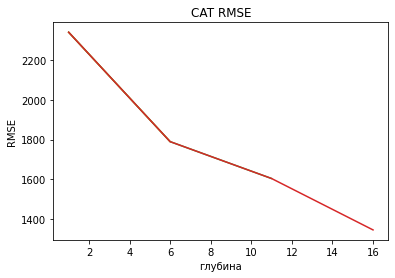

In [39]:
%%time
best_result = 5000
depth = 0
depths = []
results = []

for depth in range(1, 21, 5):
    model_cat = CatBoostRegressor(iterations=30, learning_rate=1, max_depth=depth, random_state=12345, verbose=5)
    model_cat.fit(features_train, target_train, cat_features=cat_columns)
    predictions_valid = model_cat.predict(features_train)
    result = mean_squared_error(target_train, predictions_valid) ** .5
    depths.append(depth)
    results.append(result)

    plt.plot(depths, results)
    plt.title("CAT RMSE")
    plt.xlabel("глубина")
    plt.ylabel("RMSE")
    plt.grid()
    plt.show
            
    if result < best_result:
        best_depth = depth
        best_result = result

display(best_result, best_depth)

**Вывод: глубина 16, RMSE - 1346.5116875688022, за время 52.1 s**

### Дерево решений

1997.2865110862094

13

CPU times: user 2.56 s, sys: 0 ns, total: 2.56 s
Wall time: 2.55 s


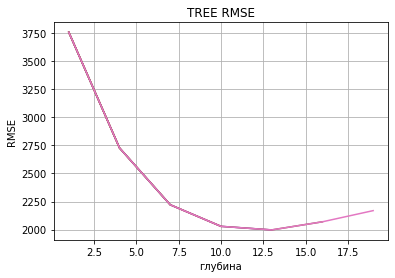

In [40]:
%%time
best_result = 5000
depth = 0
depths = []
results = []

for depth in range(1, 21, 3):
    model_tree = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model_tree.fit(features_train, target_train)
    predictions_valid = model_tree.predict(features_valid)
    result = mean_squared_error(target_valid, predictions_valid) ** 0.5
    depths.append(depth)
    results.append(result)
        
    plt.plot(depths, results)
    plt.title("TREE RMSE")
    plt.xlabel("глубина")
    plt.ylabel("RMSE")
    plt.grid()
    plt.show
            
    if result < best_result:
        best_depth = depth
        best_result = result

display(best_result, best_depth)

**Вывод: глубина 13, RMSE - 1997.2865110862094, за время 2.55 s**

### LIghtGBM

In [41]:
%%time

regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[11, 50, 100], 
                'learning_rate':[0.3],
                'random_state':[1515]}]

print('Запуск')
print()
clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print("Лучшие параметры:")
print()
print(clf.best_params_)
print()
print("Используемые параметры")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% ((mean*-1)** 0.5, params))
print()

cv_RMSE_LGBMR = (max(means)*-1) ** 0.5

Запуск

Лучшие параметры:

{'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 1515}

Используемые параметры

1786.282519 for {'learning_rate': 0.3, 'num_leaves': 11, 'random_state': 1515}
1712.869466 for {'learning_rate': 0.3, 'num_leaves': 50, 'random_state': 1515}
1702.277182 for {'learning_rate': 0.3, 'num_leaves': 100, 'random_state': 1515}

CPU times: user 18min 12s, sys: 8.01 s, total: 18min 20s
Wall time: 18min 31s


**Вывод:**

**С гиперпараметрами:'learning_rate'- 0.3, 'num_leaves'- 100, 'random_state'- 1515,  RMSE - 1702.277182. за 18min 31s.**

### Выводы

**Вывод:**
* CatBoost с наилучшим результатом RMSE с глубиной 16, RMSE - 1346.5116875688022, за время 52.1 s
* Дерево Решений с наилучшим результатом RMSE с глубиной 13, RMSE - 1997.2865110862094, за время 2.55 s
* LightGBM С гиперпараметрами:'learning_rate'- 0.3, 'num_leaves'- 100, 'random_state'- 1515, RMSE - 1702.277182 за 18min 31s.


Все модели показали RMSE меньше 2500, что и требовалось. Дерево решений показало самый быстрый результат.

## Анализ моделей

### Дерево решений

Обучение

In [48]:
%%time
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=13)
model_tree.fit(features_train, target_train)

CPU times: user 437 ms, sys: 0 ns, total: 437 ms
Wall time: 435 ms


DecisionTreeRegressor(max_depth=13, random_state=12345)

**Результат обучения: 435 ms**

Предсказания

In [49]:
%%time
predictions_valid_tree = model_tree.predict(features_valid)
display(mean_squared_error(target_valid, predictions_valid_tree) ** .5)

1997.2865110862094

CPU times: user 17.2 ms, sys: 0 ns, total: 17.2 ms
Wall time: 15.1 ms


**Результат предсказания: 15.1 ms, RMSE = 1997.2865110862094**

### CatBoost

Обучение

In [50]:
%%time
model_cat = CatBoostRegressor(iterations=30, learning_rate=1, max_depth=16, random_state=12345, 
                              verbose=5)
model_cat.fit(features_train, target_train)

0:	learn: 2204.6295744	total: 1.16s	remaining: 33.5s
5:	learn: 1730.3249826	total: 6.83s	remaining: 27.3s
10:	learn: 1606.0915599	total: 12.5s	remaining: 21.7s
15:	learn: 1520.3623085	total: 18.1s	remaining: 15.8s
20:	learn: 1461.7089958	total: 23.7s	remaining: 10.2s
25:	learn: 1407.1381663	total: 29.4s	remaining: 4.52s
29:	learn: 1371.6990011	total: 34.2s	remaining: 0us
CPU times: user 18.8 s, sys: 15.6 s, total: 34.4 s
Wall time: 34.9 s


**Результат обучения: 34.9 s**

Предсказания

In [51]:
%%time
predictions_valid_cat = model_cat.predict(features_valid)
display(mean_squared_error(target_valid, predictions_valid_cat) ** .5)

1802.4661890489551

CPU times: user 20.2 ms, sys: 4.1 ms, total: 24.3 ms
Wall time: 22.9 ms


**Результат предсказания: 22.9 ms, RMSE = 1802.4661890489551**

### LightGBM

Обучение

In [52]:
%%time
model = LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=1515)
model.fit(features_train, target_train)

CPU times: user 6.62 s, sys: 58.7 ms, total: 6.67 s
Wall time: 6.79 s


LGBMRegressor(learning_rate=0.3, num_leaves=100, random_state=1515)

**Результат обучения: 6.79 s**

Предсказания

In [53]:
%%time
target_predict = model.predict(features_test)
display(mean_squared_error(target_test, target_predict) ** 0.5)

1658.4572719510772

CPU times: user 416 ms, sys: 323 µs, total: 417 ms
Wall time: 363 ms


**Результат предсказания: 363 ms, RMSE = 1658.4572719510772**

### Выводы

При обучении получились следующие результаты по времени:

*    DecisionTreeRegressor - Результат обучения: 435 ms, Результат предсказания: 15.1 ms, RMSE = 1997.2865110862094
*    CatBoost - Результат обучения: 34.9 s, Результат предсказания: 22.9 ms, RMSE = 1802.4661890489551
*    LightGBM - Результат обучения: 6.79 s, Результат предсказания: 363 ms, RMSE = 1658.4572719510772

Все модели выдают RMSE меньше 2500. **Самой быстрой по скорости обучения и предсказаия стала модель Дерева решений.**

**Проверка лучшей модели**

In [56]:
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=13)
model_tree.fit(features_80, target_80)
predictions_test_tree = model_tree.predict(features_test)
display(mean_squared_error(target_test, predictions_test_tree) ** .5)

1926.6606514324285

## Итоговый вывод

* Произведен подбор параметров и последующее обучение 3 моделей со следующими результатами:

**CatBoost с наилучшим результатом RMSE с глубиной 16, RMSE - 1346.5116875688022, за время 52.1 s**

**Дерево Решений с наилучшим результатом RMSE с глубиной 13, RMSE - 1997.2865110862094, за время 2.55 s**

**LightGBM С гиперпараметрами:'learning_rate'- 0.3, 'num_leaves'- 100, 'random_state'- 1515, RMSE - 1702.277182 за 18min 31s.**
    
    
* Произведено измерение времени обучения и предсказаний модели со следующими результатами:

**DecisionTreeRegressor - Результат обучения: 435 ms, Результат предсказания: 15.1 ms, RMSE = 1997.2865110862094**

**CatBoost - Результат обучения: 34.9 s, Результат предсказания: 22.9 ms, RMSE = 1802.4661890489551**

**LightGBM - Результат обучения: 6.79 s, Результат предсказания: 363 ms, RMSE = 1658.4572719510772**


**Лучшей становится модель DecisionTreeRegressor.**